---
title: "2023_Kronensicherung_Plesse_Analyse"
author: "Kyell Jensen"
date: "2024-08-06"
format: pdf
editor: visual
---

# 2023_Kronensicherung_Plesse_Analyse

## Kombinierte Analyse LineScale3, TreeQinetic und Versuchsaufzeichung

Nutze eine geeignete Python 3.11 Umgebung (z. B. virtuelle Environment).

## Arbeitsumgebung vorbereiten

### IMPORT: Importieren von Standardbibliotheken

Die folgenden Bibliotheken werden importiert, um grundlegende Funktionen für Strukturierung, Datenverarbeitung, Plotting und statistische Auswertung bereit zu stellen.

In [225]:
# Struktur
from pathlib import Path
from typing import Dict, List

# Datenverarbeitung
import json
from IPython.display import Markdown, display
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from slugify import slugify  # Slugify ums strings in standard Formate zu überführen

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Statistik
from scipy.stats import linregress, f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as mc


### IMPORT: Importiere eigene Packete (hier nur für Plotter und Logger)

In [226]:
from kj_core.utils.latex_export import (
    generate_latex_table,
    generate_grouped_latex_tables,
    save_latex_table,
    build_data_dict_df
)

from kj_core.utils.labeling import (
    get_label_from_dict, 
    get_color_dict
)

In [227]:
from kj_core import CoreConfig, PlotManager, get_logger

In [228]:
# Importiere alle Einstellungen aus der project_config.py
from project_config import (
    working_directory,
    data_export_directory,
    latex_export_directory
)

###

In [229]:
CONFIG = CoreConfig(working_directory=f"{working_directory}/combined")
PLOT_MANAGER = PlotManager(CONFIG)
# CONFIG
# PLOT_MANAGER

## IMPORT: Daten Import

Lege Pfade für Daten-Importe, Daten-Exporte etc. fest (ggf. anpassen an eigene Verzeichnisstruktur), ausgelagert in gemeinsame Config für verschiedene Notebooks

In [230]:
filename_dataset = "_dataset_clean.feather"
filename_data_dict = "_data_dict_clean.json"

In [231]:
# Dateien laden
df = pd.read_feather(data_export_directory / filename_dataset)

with open(data_export_directory / filename_data_dict, "r", encoding="utf-8") as f:
    data_dict = json.load(f)

## ANALYSE: Explorative Datenanalyse

In [233]:
df.head(10)

,id,rope_datetime,treatment,release_force_target,rope_release,cable_max,sensor_name,location,direction,height,...,frequency_damped,phase_angle,y_shift,x_shift,frequency_undamped,damping_ratio,metrics_warning,pearson_r,nrmse,nmae
4,2,2022-03-23 11:24:23,free,2.8,2.72310,NaN,Elasto(90),StB,elongation,16.55,...,0.441518,0.200000,-5.287164,0.116641,0.442936,0.503994,False,0.943158,0.038866,0.018011
5,2,2022-03-23 11:24:23,free,2.8,2.72310,NaN,Elasto(92),StB,elongation,11.6,...,0.432441,-0.200000,-14.233644,-0.009730,0.436601,0.873595,False,0.929554,0.034560,0.016183
6,2,2022-03-23 11:24:23,free,2.8,2.72310,NaN,Elasto(95),StA,elongation,11.6,...,0.422702,-0.200000,-19.011309,-0.123043,0.426319,0.823807,False,0.908058,0.044873,0.024274
7,2,2022-03-23 11:24:23,free,2.8,2.72310,NaN,Elasto(98),StA,elongation,16.85,...,0.443529,-0.065967,-1.099515,0.118608,0.445993,0.663224,False,0.980663,0.029621,0.021087
8,3,2022-03-23 11:31:12,free,2.8,2.76205,NaN,Elasto(90),StB,elongation,16.55,...,0.440653,0.200000,7.775284,0.097887,0.441317,0.344951,False,0.957380,0.043035,0.018619
9,3,2022-03-23 11:31:12,free,2.8,2.76205,NaN,Elasto(92),StB,elongation,11.6,...,0.439321,-0.075771,7.052210,0.094719,0.441380,0.608931,False,0.933463,0.043534,0.021255
10,3,2022-03-23 11:31:12,free,2.8,2.76205,NaN,Elasto(95),StA,elongation,11.6,...,0.436023,-0.200000,-3.785755,-0.075741,0.438127,0.618021,False,0.938307,0.039020,0.022498
11,3,2022-03-23 11:31:12,free,2.8,2.76205,NaN,Elasto(98),StA,elongation,16.85,...,0.441350,-0.200000,-17.747289,-0.203345,0.442888,0.525070,False,0.974139,0.028693,0.020715
12,4,2022-03-23 11:54:33,free,2.8,2.73950,NaN,Elasto(90),StB,elongation,16.55,...,0.439065,0.200000,-23.445975,0.120929,0.439764,0.354677,False,0.945320,0.049764,0.021509
13,4,2022-03-23 11:54:33,free,2.8,2.73950,NaN,Elasto(92),StB,elongation,11.6,...,0.436850,-0.200000,-19.454720,0.061912,0.438829,0.598701,False,0.922665,0.050822,0.020659


In [234]:
df.columns

Index(['id', 'rope_datetime', 'treatment', 'release_force_target',
       'rope_release', 'cable_max', 'sensor_name', 'location', 'direction',
       'height', 'diameter', 'max_strain', 'max_compression', 'm_amplitude',
       'm_amplitude_2', 'initial_amplitude', 'damping_coeff',
       'frequency_damped', 'phase_angle', 'y_shift', 'x_shift',
       'frequency_undamped', 'damping_ratio', 'metrics_warning', 'pearson_r',
       'nrmse', 'nmae'],
      dtype='object')

### COMBINED: Definition von Darstellungsstandards
Festlegen von Farbcodes für einheitliche Darstellung von Sensoren und Behandlungsvarianten für alle nachfolgenden Plots.

In [235]:
color_palette = PLOT_MANAGER.color_palette_list

# Für die Spalte "treatment":
treatment_color_dict = get_color_dict(df, "treatment", PLOT_MANAGER.color_palette_list)
# Für die Spalte "sensor_name":
sensor_color_dict = get_color_dict(df, "sensor_name", PLOT_MANAGER.color_palette_list)

Index(['free', 'gefa_dynamic', 'cobra_static'], dtype='object')
Index(['Elasto(90)', 'Elasto(92)', 'Elasto(95)', 'Elasto(98)'], dtype='object')


### LATEX-EXPORT: Latex-Export von Daten für Anhang

In [264]:
variables_2 = ['id', 'sensor_name', 'treatment', 'm_amplitude', 'm_amplitude_2', 'initial_amplitude', 'damping_coeff', 'damping_ratio', 'frequency_damped', 'frequency_undamped', 'y_shift', 'pearson_r', 'nmae']

# DataFrame kopieren und die gewünschten Spalten auswählen
df_latex = df.copy()[variables_2]

# Spaltennamen mit den Kurzbezeichnungen (Zeichen) aus dem data_dict umbenennen
df_latex = df_latex.rename(columns={var: data_dict[var]["Zeichen"] for var in variables_2})
# Funktionsaufruf mit Beispielparametern
generate_grouped_latex_tables(
    df_latex=df_latex,
    caption="Feldversuch 2 - Ergebnisse, Schwingungsparameter vollständig",
    column_format="lrl|rrr|rr|rr|r|rr",
    group_by="treatment",
    latex_export_directory=latex_export_directory
)

Content saved to: C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\export_latex\feldversuch_2_ergebnisse_schwingungsparameter_vollstandig.tex


### PTQ: Analyse der Schwingungsparameter

In diesem Abschnitt werden die Schwingungsparameter statistisch ausgewertet. Ziel ist es, den Einfluss verschiedener Behandlungsvarianten (treatment) auf die gemessenen Schwingungsparameter zu untersuchen und dabei auch den potenziellen Einfluss der Vorspannung (rope_release) und Sensorposition (sensor_name) zu berücksichtigen.


In [193]:
variables = [
    'm_amplitude', 
    'm_amplitude_2',
    'max_strain',
    'max_compression',
    'initial_amplitude',
    'damping_coeff', 
    'damping_ratio', 
    'frequency_damped', 
    'frequency_undamped',
    'pearson_r',
    #'nrmse', 
    'nmae'
]

#### Systematischer Einfluss der Sensorposition

Ziel: Visuell erkennen, ob unterschiedliche Sensoren konsistent andere Werte liefern.

In [194]:
# Plot erstellen
for var in variables:
    fig = plt.figure(figsize=(8, 5))
    sns.boxplot(x="sensor_name", y=var, data=df, dodge=True)
    # Titel und Achsentitel setzen
    plt.title(f"Einfluss der Sensoren auf {get_label_from_dict(var, data_dict, use_titel=True)}")
    plt.xlabel("Sensorname")
    plt.ylabel(get_label_from_dict(var, data_dict, use_full=True))
    plt.tight_layout()
    #plt.show(
    PLOT_MANAGER.save_plot(fig, filename=f"effect_sensor_{var}", subdir="ptq_osc/sensor_only")

Ziel: Feststellen, ob die Variation durch unterschiedliche Sensorpostion relativ zur behandlungsbedingten Variation relevant ist.

In [195]:
# Plot erstellen
for var in variables:
    fig = plt.figure(figsize=(8, 5))
    sns.boxplot(x="sensor_name", y=var, data=df, hue="treatment", palette=treatment_color_dict,  dodge=True)
    # Stripplot: Punkte zur Veranschaulichung der Verteilung
    sns.stripplot(x="sensor_name", y=var, data=df, hue="treatment", palette=treatment_color_dict, dodge=True, alpha=1, jitter=True, size=5, legend=False)
    # Titel und Achsentitel setzen
    plt.title(f"Einfluss der Behandlung auf {get_label_from_dict(var, data_dict, use_titel=True)} gruppiert über Sensoren")
    plt.xlabel("Sensorname")
    plt.ylabel(get_label_from_dict(var, data_dict, use_full=True))
    plt.tight_layout()
    #plt.show()
    PLOT_MANAGER.save_plot(fig, filename=f"effect_sensor_treatment_{var}", subdir="ptq_osc/sensor_treatment")

Ziel: Feststellen, ob die Variation durch unterschiedliche Behandlungen relativ zur sensorbedingten Variation relevant ist.

In [196]:
# Plot erstellen
for var in variables:
    fig = plt.figure(figsize=(8, 5))
    sns.boxplot(x="treatment", y=var, data=df, palette=sensor_color_dict, hue='sensor_name')
    sns.stripplot(x="treatment", y=var, data=df, palette=sensor_color_dict, hue='sensor_name', dodge=True, alpha=1, jitter=True, size=5, legend=False)
    plt.title(f"Einfluss der Sensoren auf {get_label_from_dict(var, data_dict, use_titel=True)} gruppiert über Behandlung")
    plt.xlabel("Behandlungsvariante")
    plt.ylabel(get_label_from_dict(var, data_dict, use_full=True))
    plt.tight_layout()
    #plt.show()
    PLOT_MANAGER.save_plot(fig, filename=f"effect_treatment_sensor_{var}", subdir="ptq_osc/treatment_sensor")

##### Statistische Untersuchung des Effektes der Sensorposition innerhalb einer Beobachtung

In [197]:
# 1. Deskriptive Statistiken pro Sensor
summary_by_sensor = df.groupby('sensor_name', observed=False)[variables].describe()
summary_by_sensor

m_amplitude                                                  \
                  count        mean        std     min      25%     50%   
sensor_name                                                               
Elasto(90)         27.0  251.248148  30.276998  198.30  230.025  247.60   
Elasto(92)         27.0  136.624074  27.426785   91.65  116.200  130.70   
Elasto(95)         27.0  123.061111  26.037755   81.90  105.000  117.95   
Elasto(98)         27.0  141.233333  13.683265  114.35  131.500  141.90   

                             m_amplitude_2              ... pearson_r  \
                 75%     max         count        mean  ...       75%   
sensor_name                                             ...             
Elasto(90)   275.225  309.85          27.0  130.094444  ...  0.954331   
Elasto(92)   148.300  191.30          27.0   44.124074  ...  0.929332   
Elasto(95)   136.425  173.95          27.0   52.394444  ...  0.922548   
Elasto(98)   153.200  170.85          27.0  110.111111  ...  0.975588   

                       nmae                                                    \
                  max count      mean       std       min       25%       50%   
sensor_name                                                                     
Elasto(90)   0.972302  27.0  0.023165  0.009357  0.014277  0.018246  0.021509   
Elasto(92)   0.935316  27.0  0.029160  0.006568  0.016183  0.025229  0.028271   
Elasto(95)   0.941718  27.0  0.033910  0.007446  0.022498  0.029312  0.032552   
Elasto(98)   0.987644  27.0  0.030302  0.009289  0.019387  0.021929  0.028730   

                                 
                  75%       max  
sensor_name                      
Elasto(90)   0.025602  0.062792  
Elasto(92)   0.033684  0.041554  
Elasto(95)   0.037804  0.050641  
Elasto(98)   0.036272  0.054711  

[4 rows x 88 columns]

In [200]:
# 3. ANOVA: Teste, ob die Unterschiede zwischen den Sensoren signifikant sind
print("\nANOVA-Tests für Unterschiede zwischen den Sensoren:")
for var in variables:
    # Fit eines linearen Modells mit sensor_name als Prädiktor
    model = smf.ols(formula=f"{var} ~ C(sensor_name)", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"\nANOVA für {var}:")
    print(anova_table)


ANOVA-Tests für Unterschiede zwischen den Sensoren:

ANOVA für m_amplitude:
                       sum_sq     df           F        PR(>F)
C(sensor_name)  284912.661574    3.0  149.907389  1.270263e-37
Residual         65887.160926  104.0         NaN           NaN

ANOVA für m_amplitude_2:
                       sum_sq     df          F        PR(>F)
C(sensor_name)  145674.651736    3.0  79.526795  8.219855e-27
Residual         63501.296852  104.0        NaN           NaN

ANOVA für max_strain:
                       sum_sq     df           F        PR(>F)
C(sensor_name)  492818.234352    3.0  180.397796  4.550338e-41
Residual         94703.848148  104.0         NaN           NaN

ANOVA für max_compression:
                       sum_sq     df          F        PR(>F)
C(sensor_name)  206732.324722    3.0  50.247393  3.723270e-20
Residual        142628.704444  104.0        NaN           NaN

ANOVA für initial_amplitude:
                      sum_sq     df         F   PR(>F)
C(sensor_na

##### Optimaler Ansatz: Versuche Mixed-Linear Model

Die Daten sind hierarchisch: mehrere Messungen (vier Sensoren) pro Beobachtungseinheit (`id`). Ein Mixed-Effects Modell könnte diese Struktur abbilden, indem zufällige Effekte für `id` und feste Effekte für `treatment` sowie `sensor_name` berücksichtigt werden. Zusätzlich kann `rope_release` als Kovariate eingeführt werden. Dieser Ansatz wären theoretisch optimal, aber aufgrund der geringen Stichprobengröße und der komplexen Datenstruktur treten Konvergenzprobleme auf.

In [ ]:
# Ergebnisse als Dictionary speichern
results_dict = {}

for var in variables:
    model = smf.mixedlm(
        f"{var} ~ C(treatment) + C(sensor_name) + rope_release", 
        data=df, 
        groups=df["id"]
    )
    result = model.fit()
    print(f"\n### Ergebnisse für {var}:")
    print(result.summary())
    print("\n")

Um dennoch aussagekräftige Ergebnisse zu erhalten, wird ein zweistufiges Verfahren genutzt.
Zwei Varianten:
- Mittlung über alle Sensoren innerhalb eine Beobachtung. Die Variation zwischen den Sensoren bleibt unberücksichtigt und verfälscht ggf. die Ergebnisse. Vorteil: Sehr einfach und stabil
- Werte um Sensor-Effekt manuell adjustieren und dann aggregieren wie zuvor. Vorteile: Sensoren verfälschen nicht die Ergebnisse. Nachteil ist die höhere Komplexität und das die Gesamtvariation der Modell am ende verfälsch ist.

##### Alternative 1: Vereinfachtes Vorgehen durch Aggregation (Mittelwert)

In [215]:
df_mean = df.groupby("id").agg({var: "mean" for var in variables}).reset_index()
# Benenne die Spalten um, damit klar ist, dass es sich um Mittelwerte handelt.
df_mean = df_mean.rename(columns={var: f"{var}_mean" for var in variables})

# Füge zusätzliche Variablen (z.B. treatment und rope_release) hinzu.
treatment_df = df[["id", "treatment", "rope_release"]].drop_duplicates()
df_mean = df_mean.merge(treatment_df, on="id")
df_mean.describe()

,id,m_amplitude_mean,m_amplitude_2_mean,max_strain_mean,max_compression_mean,initial_amplitude_mean,damping_coeff_mean,damping_ratio_mean,frequency_damped_mean,frequency_undamped_mean,pearson_r_mean,nmae_mean,rope_release
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,15.000000,163.041667,84.181019,248.391667,-93.480556,169.790250,0.434036,0.968812,0.456238,0.463587,0.888360,0.029134,2.371609
std,7.937254,22.751519,21.178032,25.407331,31.077756,5.462118,0.200727,0.442173,0.022212,0.027848,0.053055,0.006646,0.320477
min,2.000000,124.700000,50.825000,204.125000,-144.950000,164.414861,0.218833,0.499237,0.435009,0.436606,0.799567,0.019889,1.946800
25%,8.500000,148.368750,61.868750,232.437500,-125.262500,166.161477,0.276357,0.636314,0.437784,0.439283,0.842485,0.024730,2.012975
50%,15.000000,162.850000,87.362500,244.750000,-80.800000,169.854061,0.336295,0.748273,0.450018,0.453386,0.894191,0.027968,2.356550
75%,21.500000,181.712500,102.618750,262.400000,-73.425000,170.241598,0.692071,1.469274,0.466431,0.483996,0.946130,0.033468,2.748225
max,28.000000,204.950000,115.737500,297.150000,-43.775000,189.345841,0.748626,1.757161,0.508053,0.522475,0.956986,0.043212,2.780700


##### Alternative 2: Werte um Sensor-Effekt und Vorspannung Adjustieren und dann Aggregieren (Mittelwert)

Nicht jeder Parameter wird durch `rope_release` beeinflusst. Nur für jene Parameter, bei denen ein signifikanter Einfluss von `rope_release` festgestellt wird, soll dieser Effekt herausgerechnet werden. Auf diese Weise entstehen "bereinigte" Werte, in denen der lineare Einfluss von `rope_release` entfernt ist.

In [219]:
# Definiere die Liste der Variablen, bei denen rope_release entfernt werden soll
relevant_vars_rope_release = ['m_amplitude', 'm_amplitude_2', 'max_strain', 'max_compression']
model_dict = {}
# Erstelle eine Kopie des Original-DataFrames
df_copy = df.copy()

for var in variables:
    try:
        # Wähle die Modellformel abhängig davon, ob rope_release berücksichtigt werden soll
        if var in relevant_vars_rope_release:
            formula = f"{var} ~ C(sensor_name) + rope_release"
        else:
            formula = f"{var} ~ C(sensor_name)"
            
        model = smf.ols(formula, data=df).fit()
        
        # Speichere das Modell im Dictionary (so hast du per Variable die komplette Summary)
        model_dict[var] = model
        # Berechne adjustierte Werte:
        # y_adj = y - (fitted effect - globaler Intercept)
        df_copy[f"{var}_adj"] = df_copy[var] - (model.fittedvalues - model.params['Intercept'])
    except Exception as e:
        print(f"Fehler bei {var}: {e}")

# Aggregiere über die ID – hier wird der Mittelwert der adjustierten Werte berechnet.
df_adj = df_copy.groupby("id").agg({f"{var}_adj": "mean" for var in variables}).reset_index()
# Ergänze zusätzliche Variablen (z.B. treatment und rope_release)
treatment_df = df[["id", "treatment", "rope_release"]].drop_duplicates()
df_adj = df_adj.merge(treatment_df, on="id")

# Ausgabe der deskriptiven Statistik
print(df_adj.describe())


              id  m_amplitude_adj  m_amplitude_2_adj  max_strain_adj  \
count  27.000000        27.000000          27.000000       27.000000   
mean   15.000000       157.368958         106.177715      217.418613   
std     7.937254        18.886461          20.929978       16.410941   
min     2.000000       126.721101          73.696181      186.504963   
25%     8.500000       138.251643          83.173218      206.941647   
50%    15.000000       157.684238         109.601825      214.816110   
75%    21.500000       177.379976         127.421895      232.252152   
max    28.000000       183.821853         134.024166      242.458537   

       max_compression_adj  initial_amplitude_adj  damping_coeff_adj  \
count            27.000000              27.000000          27.000000   
mean           -117.547632             175.130475           0.267204   
std              30.785344               5.462118           0.200727   
min            -168.905719             169.755086           0.0

##### Zusammenführen beider Alternativen für Vergleich

In [220]:
# --- Zusammenführen beider Ansätze ---
# Beide DataFrames enthalten nun jeweils den Mittelwert pro ID:
# - df_mean: direkte Mittelwerte mit Suffix _mean
# - df_adj: sensor-adjustierte Mittelwerte mit Suffix _adj
grouped_df = pd.merge(df_mean, df_adj, on=["id", "treatment", "rope_release"], how="inner")
grouped_df

,id,m_amplitude_mean,m_amplitude_2_mean,max_strain_mean,max_compression_mean,initial_amplitude_mean,damping_coeff_mean,damping_ratio_mean,frequency_damped_mean,frequency_undamped_mean,...,m_amplitude_2_adj,max_strain_adj,max_compression_adj,initial_amplitude_adj,damping_coeff_adj,damping_ratio_adj,frequency_damped_adj,frequency_undamped_adj,pearson_r_adj,nmae_adj
0,2,198.6125,103.9750,293.625,-124.350,169.960362,0.310671,0.716155,0.435047,0.437962,...,122.427053,241.378667,-143.752300,175.300587,0.143838,0.300369,0.453298,0.450920,0.967104,0.013920
1,3,204.9500,115.1000,293.800,-128.225,170.248463,0.230183,0.524243,0.439337,0.440928,...,133.159258,239.196295,-147.110378,175.588688,0.063350,0.108458,0.457588,0.453886,0.977568,0.014803
2,4,199.6500,115.7375,272.650,-136.150,170.814318,0.218833,0.499237,0.438575,0.440015,...,134.024166,219.411089,-155.334649,176.154543,0.052001,0.083451,0.456826,0.452973,0.974564,0.015818
3,5,188.4000,108.7875,267.575,-116.775,170.279813,0.284570,0.655074,0.435206,0.437687,...,130.853370,237.017089,-140.933108,175.620039,0.117738,0.239288,0.453457,0.450645,0.973763,0.016810
4,6,186.4250,110.7250,229.975,-144.950,184.280012,0.228966,0.524325,0.436994,0.438551,...,132.637079,198.494113,-168.905719,189.620237,0.062134,0.108539,0.455245,0.451509,0.983732,0.014754
5,7,188.6250,111.0500,251.300,-144.325,166.418673,0.230392,0.527382,0.436914,0.438531,...,133.070993,220.472762,-168.424050,171.758898,0.063559,0.111597,0.455165,0.451489,0.981784,0.019778
6,8,168.9625,102.7000,215.500,-126.325,170.546205,0.226999,0.522647,0.435009,0.436606,...,128.803239,209.172478,-155.796316,175.886430,0.060166,0.106862,0.453260,0.449564,0.981424,0.017783
7,9,165.8375,102.5375,221.200,-126.175,170.234733,0.268143,0.617555,0.435197,0.437420,...,128.500563,214.031208,-155.461843,175.574958,0.101311,0.201769,0.453448,0.450378,0.971988,0.021725
8,10,163.3000,100.0625,209.275,-130.575,170.351945,0.235773,0.542241,0.435257,0.436960,...,126.343228,204.012683,-160.279892,175.692170,0.068940,0.126455,0.453508,0.449918,0.982202,0.017395
9,11,177.0625,94.5000,247.825,-120.625,189.345841,0.351440,0.773543,0.455380,0.458899,...,112.601614,193.475492,-139.566118,194.686066,0.184608,0.357757,0.473630,0.471857,0.928857,0.020250


Plotten und Vergleich beider Ergebnisse

In [241]:
for var in variables:
    # Transformiere die Daten in das Long-Format: 
    # Es werden die beiden Spalten f"{var}_mean" und f"{var}_adj" unter einer neuen Spalte "aggregation" zusammengeführt,
    # und die Werte in der Spalte "value" gespeichert.
    df_long = pd.melt(
        grouped_df,
        id_vars=["id", "treatment", "rope_release"],
        value_vars=[f"{var}_mean", f"{var}_adj"],
        var_name="aggregation",
        value_name="value"
    )
    # Kürze die Beschriftungen, sodass nur "mean" bzw. "adj" übrig bleiben
    df_long["aggregation"] = df_long["aggregation"].str.replace(f"{var}_", "", regex=False)
    
    # Erstelle den Plot: Boxplots nach Behandlung, getrennt nach Aggregationsmethode
    fig = plt.figure(figsize=(8, 5))
    sns.boxplot(x="treatment", y="value", hue="aggregation", data=df_long, dodge=True)
    
    # Titel und Achsentitel setzen
    plt.title(f"Einfluss der Behandlung auf {get_label_from_dict(var, data_dict, use_titel=True)}")
    plt.xlabel("Behandlung")
    plt.ylabel(get_label_from_dict(var, data_dict, use_full=True))
    plt.tight_layout()
    
    # Speichere den Plot (ersetze PLOT_MANAGER.save_plot durch plt.show() oder deine eigene Funktion, falls nötig)
    PLOT_MANAGER.save_plot(fig, filename=f"effect_treatment_{var}", subdir="ptq_osc/treatment_comparison")


In [265]:
def extract_model_info(model):
    """
    Extrahiert zentrale Kennzahlen aus einem OLS-Modell.
    Liefert ein Dictionary mit R-squared, Adj. R-squared, sowie den Koeffizienten,
    Standardfehler, t-Werten und p-Werten für alle Parameter.
    """
    info = {
        "R²": model.rsquared,
        "adj_R²": model.rsquared_adj,
    }
    # Iteriere über alle Parameter im Modell
    for param in model.params.index:
        info[f"coef_{param}"] = model.params[param]
        info[f"std_err_{param}"] = model.bse[param]
        info[f"t_{param}"] = model.tvalues[param]
        info[f"p_{param}"] = model.pvalues[param]
    return info

In [266]:
# Erstelle eine Liste, in der pro Variable das extrahierte Dictionary gespeichert wird.
model_info_list = []
for var, model in model_dict.items():
    info = extract_model_info(model)
    info['variable'] = var  # Variable als Kennung hinzufügen
    model_info_list.append(info)

# Konvertiere die Liste in einen DataFrame und setze "variable" als Index
df_model_info = pd.DataFrame(model_info_list).set_index("variable")
df_model_info.index.name = "Statistik"
df_model_info = df_model_info.T

In [267]:
def format_value(x):
    # Prüfe, ob der Wert numerisch ist
    if isinstance(x, (int, float, np.number)):
        if abs(x) < 0.0001:
            return f"{x:.2e}"
        else:
            return f"{x:.2f}"
    return x

# Wende die Funktion auf alle Zellen von df_model_info an
df_model_info = df_model_info.applymap(format_value)
df_model_info

C:\Users\mail\AppData\Local\Temp\ipykernel_18816\3004503431.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_model_info = df_model_info.applymap(format_value)


Statistik,m_amplitude,m_amplitude_2,max_strain,max_compression,initial_amplitude,damping_coeff,damping_ratio,frequency_damped,frequency_undamped,pearson_r,nmae
R²,0.86,0.70,0.91,0.60,0.09,0.30,0.34,0.23,0.14,0.27,0.19
adj_R²,0.85,0.69,0.90,0.58,0.06,0.28,0.32,0.20,0.11,0.24,0.16
coef_Intercept,157.37,106.18,217.42,-117.55,175.13,0.27,0.55,0.47,0.48,0.92,0.02
std_err_Intercept,16.40,18.48,17.44,27.75,2.05,0.04,0.11,0.01,0.01,0.01,0.00
t_Intercept,9.60,5.75,12.47,-4.24,85.27,6.03,5.26,67.74,67.27,63.71,14.59
p_Intercept,5.86e-16,9.38e-08,2.67e-22,4.97e-05,4.54e-98,2.49e-08,7.60e-07,7.39e-88,1.50e-87,3.77e-85,6.70e-27
coef_C(sensor_name)[T.Elasto(92)],-114.62,-85.97,-128.81,98.13,-8.36,0.33,0.87,-0.04,-0.03,-0.07,0.01
std_err_C(sensor_name)[T.Elasto(92)],5.95,6.70,6.32,10.06,2.90,0.06,0.15,0.01,0.01,0.02,0.00
t_C(sensor_name)[T.Elasto(92)],-19.28,-12.83,-20.38,9.75,-2.88,5.22,5.85,-4.48,-3.32,-3.48,2.67
p_C(sensor_name)[T.Elasto(92)],5.91e-36,4.35e-23,6.43e-38,2.61e-16,0.00,9.25e-07,5.80e-08,1.90e-05,0.00,0.00,0.01


In [268]:
# Manuelles Escapen der Unterstriche im Index
df_model_info.index = df_model_info.index.astype(str).str.replace('(sensor_name)[T.', r'(sensor)[')
df_model_info.index = df_model_info.index.astype(str).str.replace('_', r'\_')


# Spaltennamen mit den Kurzbezeichnungen (Zeichen) aus dem data_dict umbenennen
df_model_info = df_model_info.rename(columns={var: data_dict[var]["Zeichen"] for var in variables})

column_format = "l" + "r" * (len(df_model_info.columns))
latex_string = df_model_info.to_latex(index=True, escape=False, float_format="%.2f", column_format=column_format)

# Definiere Beschriftung und lange Beschriftung (Caption)
caption = "Feldversuch 2: Ergebnisse, Zusammenfassung der OLS-Modelle"
caption_long = "Übersicht über zentrale Kennzahlen der OLS-Modelle: R², Adjusted R², Koeffizienten, Standardfehler, t-Werte und p-Werte für alle Parameter."

# Funktion zum Speichern der LaTeX-Tabelle (du passt diese Funktion ggf. an deine Gegebenheiten an)
save_latex_table(latex_string, caption, latex_export_directory, caption_long)

Content saved to: C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\export_latex\feldversuch_2_ergebnisse_zusammenfassung_der_ols_modelle.tex


Auf dieser Basis können einfache OLS-Modelle geschätzt werden, z. B. `Parameter ~ C(treatment)`. Diese Modelle sind einfacher und sollten stabil konvergieren.

#### Systematischer Einfluss der Behandlungsvariante

In [242]:
grouped_df

,id,m_amplitude_mean,m_amplitude_2_mean,max_strain_mean,max_compression_mean,initial_amplitude_mean,damping_coeff_mean,damping_ratio_mean,frequency_damped_mean,frequency_undamped_mean,...,m_amplitude_2_adj,max_strain_adj,max_compression_adj,initial_amplitude_adj,damping_coeff_adj,damping_ratio_adj,frequency_damped_adj,frequency_undamped_adj,pearson_r_adj,nmae_adj
0,2,198.6125,103.9750,293.625,-124.350,169.960362,0.310671,0.716155,0.435047,0.437962,...,122.427053,241.378667,-143.752300,175.300587,0.143838,0.300369,0.453298,0.450920,0.967104,0.013920
1,3,204.9500,115.1000,293.800,-128.225,170.248463,0.230183,0.524243,0.439337,0.440928,...,133.159258,239.196295,-147.110378,175.588688,0.063350,0.108458,0.457588,0.453886,0.977568,0.014803
2,4,199.6500,115.7375,272.650,-136.150,170.814318,0.218833,0.499237,0.438575,0.440015,...,134.024166,219.411089,-155.334649,176.154543,0.052001,0.083451,0.456826,0.452973,0.974564,0.015818
3,5,188.4000,108.7875,267.575,-116.775,170.279813,0.284570,0.655074,0.435206,0.437687,...,130.853370,237.017089,-140.933108,175.620039,0.117738,0.239288,0.453457,0.450645,0.973763,0.016810
4,6,186.4250,110.7250,229.975,-144.950,184.280012,0.228966,0.524325,0.436994,0.438551,...,132.637079,198.494113,-168.905719,189.620237,0.062134,0.108539,0.455245,0.451509,0.983732,0.014754
5,7,188.6250,111.0500,251.300,-144.325,166.418673,0.230392,0.527382,0.436914,0.438531,...,133.070993,220.472762,-168.424050,171.758898,0.063559,0.111597,0.455165,0.451489,0.981784,0.019778
6,8,168.9625,102.7000,215.500,-126.325,170.546205,0.226999,0.522647,0.435009,0.436606,...,128.803239,209.172478,-155.796316,175.886430,0.060166,0.106862,0.453260,0.449564,0.981424,0.017783
7,9,165.8375,102.5375,221.200,-126.175,170.234733,0.268143,0.617555,0.435197,0.437420,...,128.500563,214.031208,-155.461843,175.574958,0.101311,0.201769,0.453448,0.450378,0.971988,0.021725
8,10,163.3000,100.0625,209.275,-130.575,170.351945,0.235773,0.542241,0.435257,0.436960,...,126.343228,204.012683,-160.279892,175.692170,0.068940,0.126455,0.453508,0.449918,0.982202,0.017395
9,11,177.0625,94.5000,247.825,-120.625,189.345841,0.351440,0.773543,0.455380,0.458899,...,112.601614,193.475492,-139.566118,194.686066,0.184608,0.357757,0.473630,0.471857,0.928857,0.020250


In [251]:
df_adj.columns = df_adj.columns.str.replace('_adj$', '', regex=True)
desired_order = ['id', 'treatment', 'rope_release']
other_columns = [col for col in df_adj.columns if col not in desired_order]
new_order = desired_order + other_columns
df_adj = df_adj[new_order]
df_adj

,id,treatment,rope_release,m_amplitude,m_amplitude_2,max_strain,max_compression,initial_amplitude,damping_coeff,damping_ratio,frequency_damped,frequency_undamped,pearson_r,nmae
0,2,free,2.72310,179.026173,122.427053,241.378667,-143.752300,175.300587,0.143838,0.300369,0.453298,0.450920,0.967104,0.013920
1,3,free,2.76205,183.821853,133.159258,239.196295,-147.110378,175.588688,0.063350,0.108458,0.457588,0.453886,0.977568,0.014803
2,4,free,2.73950,179.414486,134.024166,219.411089,-155.334649,176.154543,0.052001,0.083451,0.456826,0.452973,0.974564,0.015818
3,5,free,2.36475,182.998813,130.853370,237.017089,-140.933108,175.620039,0.117738,0.239288,0.453457,0.450645,0.973763,0.016810
4,6,free,2.38000,180.420148,132.637079,198.494113,-168.905719,189.620237,0.062134,0.108539,0.455245,0.451509,0.983732,0.014754
5,7,free,2.36920,183.047661,133.070993,220.472762,-168.424050,171.758898,0.063559,0.111597,0.455165,0.451489,0.981784,0.019778
6,8,free,1.96440,179.409005,128.803239,209.172478,-155.796316,175.886430,0.060166,0.106862,0.453260,0.449564,0.981424,0.017783
7,9,free,1.97830,175.733779,128.500563,214.031208,-155.461843,175.574958,0.101311,0.201769,0.453448,0.450378,0.971988,0.021725
8,10,free,1.94680,174.443194,126.343228,204.012683,-160.279892,175.692170,0.068940,0.126455,0.453508,0.449918,0.982202,0.017395
9,11,gefa_dynamic,2.75785,156.100609,112.601614,193.475492,-139.566118,194.686066,0.184608,0.357757,0.473630,0.471857,0.928857,0.020250


In [86]:
import pandas as pd
from tabulate import tabulate
import re

# Liste der Variablen, die in die Tabelle übernommen werden sollen
variables_spec = [
    'm_amplitude_2',
    'max_compression',
    'damping_coeff',
    'damping_ratio',
    'frequency_damped',
    'frequency_undamped',
]

# Umbenennung der Spalten für LaTeX-Notation
column_rename_map = {
    'm_amplitude_2': r'$mA_2$',
    'max_compression': r'$\text{max\_C}$',
    'damping_coeff': r'$\delta$',
    'damping_ratio': r'$D$',
    'frequency_damped': r'$f_d$',
    'frequency_undamped': r'$f_0$',
}

# Funktion zur Erstellung der Modellgüte-Kennzahlen für alle Variablen
def create_model_metrics_table(variables, results):
    metrics_data = {
        "Kennzahl": ["R²", "Adj. R²", "F-St.", "AIC", "N"]
    }

    for var in variables:
        col_name = column_rename_map.get(var, var)  # Verwende gekürzten Namen, falls vorhanden
        if var not in results or 'error' in results[var]:
            metrics_data[col_name] = ["n/a"] * 5
        else:
            model = results[var]['model']
            metrics_data[col_name] = [
                f"{model.rsquared:.4f}",
                f"{model.rsquared_adj:.4f}",
                f"{model.fvalue:.4f}",
                f"{model.aic:.4f}",
                f"{model.nobs:.0f}"
            ]

    # Erstelle die Tabelle mit tabulate
    metrics_df = pd.DataFrame(metrics_data)
    return tabulate(
        metrics_df,
        headers="keys",
        tablefmt="latex_raw",
        floatfmt=".4f",
        showindex=False)

# Funktion zur Erstellung einer LaTeX-Tabelle für die Koeffizienten einer Variable
def create_latex_table_for_variable(var, results):
    if var not in results:
        return f"%% Keine Ergebnisse für Variable {var} vorhanden."
    
    model_result = results[var]
    if 'error' in model_result:
        return f"%% Fehler beim Anpassen des Modells für {var}: {model_result['error']}"
    
    model = model_result['model']
    summary = model.summary2().tables[1]  # Zugriff auf die Tabelle der Koeffizienten

    # Erstelle eine LaTeX-Tabelle mit tabulate für die Koeffizienten
    latex_table = tabulate(
        summary,
        headers=summary.columns,
        tablefmt="latex_booktabs",
        floatfmt=".4f",
        showindex=True
    )

    # Escape Unterstriche in der Variable für LaTeX
    escaped_var = re.sub(r'_', r'\_', var)
    shortened_var = column_rename_map.get(var, escaped_var)

    # Füge die LaTeX-Caption zur Tabelle hinzu
    return f"""
\\begin{{table}}[ht]
    \\centering
    \\caption{{Modellzusammenfassung für {escaped_var} ({shortened_var})}}
    \\begin{{adjustbox}}{{max width=\\textwidth}}
    {latex_table}
    \\end{{adjustbox}}
\\end{{table}}
"""

# Erstelle die Modellgüte-Tabelle für alle Variablen
latex_metrics_table = create_model_metrics_table(variables_spec, results)
print("""
\\begin{table}[ht]
    \\centering
    \\caption{Modellgüte für alle Variablen}
    \\begin{adjustbox}{max width=\\textwidth}
""")
print(latex_metrics_table)
print("""
    \\end{adjustbox}
\\end{table}

\\vspace{1cm}
""")

# Erstelle und print die LaTeX-Tabellen für die Koeffizienten jeder Variable
for var in variables_spec:
    latex_output = create_latex_table_for_variable(var, results)
    print(latex_output)


\begin{table}[ht]
    \centering
    \caption{Modellgüte für alle Variablen}
    \begin{adjustbox}{max width=\textwidth}

\begin{tabular}{lrrrrrr}
\hline
 Kennzahl   &   $mA_2$ &   $\text{max\_C}$ &   $\delta$ &      $D$ &     $f_d$ &     $f_0$ \\
\hline
 R²         &   0.9701 &            0.8572 &     0.9832 &   0.9601 &    0.7867 &    0.8841 \\
 Adj. R²    &   0.9662 &            0.8386 &     0.9818 &   0.9568 &    0.7689 &    0.8745 \\
 F-St.      & 248.8726 &           46.0304 &   702.5981 & 288.8137 &   44.2584 &   91.5628 \\
 AIC        & 153.6830 &          216.6194 &  -115.4539 & -49.4460 & -165.6975 & -169.9620 \\
 N          &  27.0000 &           27.0000 &    27.0000 &  27.0000 &   27.0000 &   27.0000 \\
\hline
\end{tabular}

    \end{adjustbox}
\end{table}

\vspace{1cm}


\begin{table}[ht]
    \centering
    \caption{Modellzusammenfassung für m\_amplitude\_2 ($mA_2$)}
    \begin{adjustbox}{max width=\textwidth}
    \begin{tabular}{lrrrrrr}
\toprule
                        

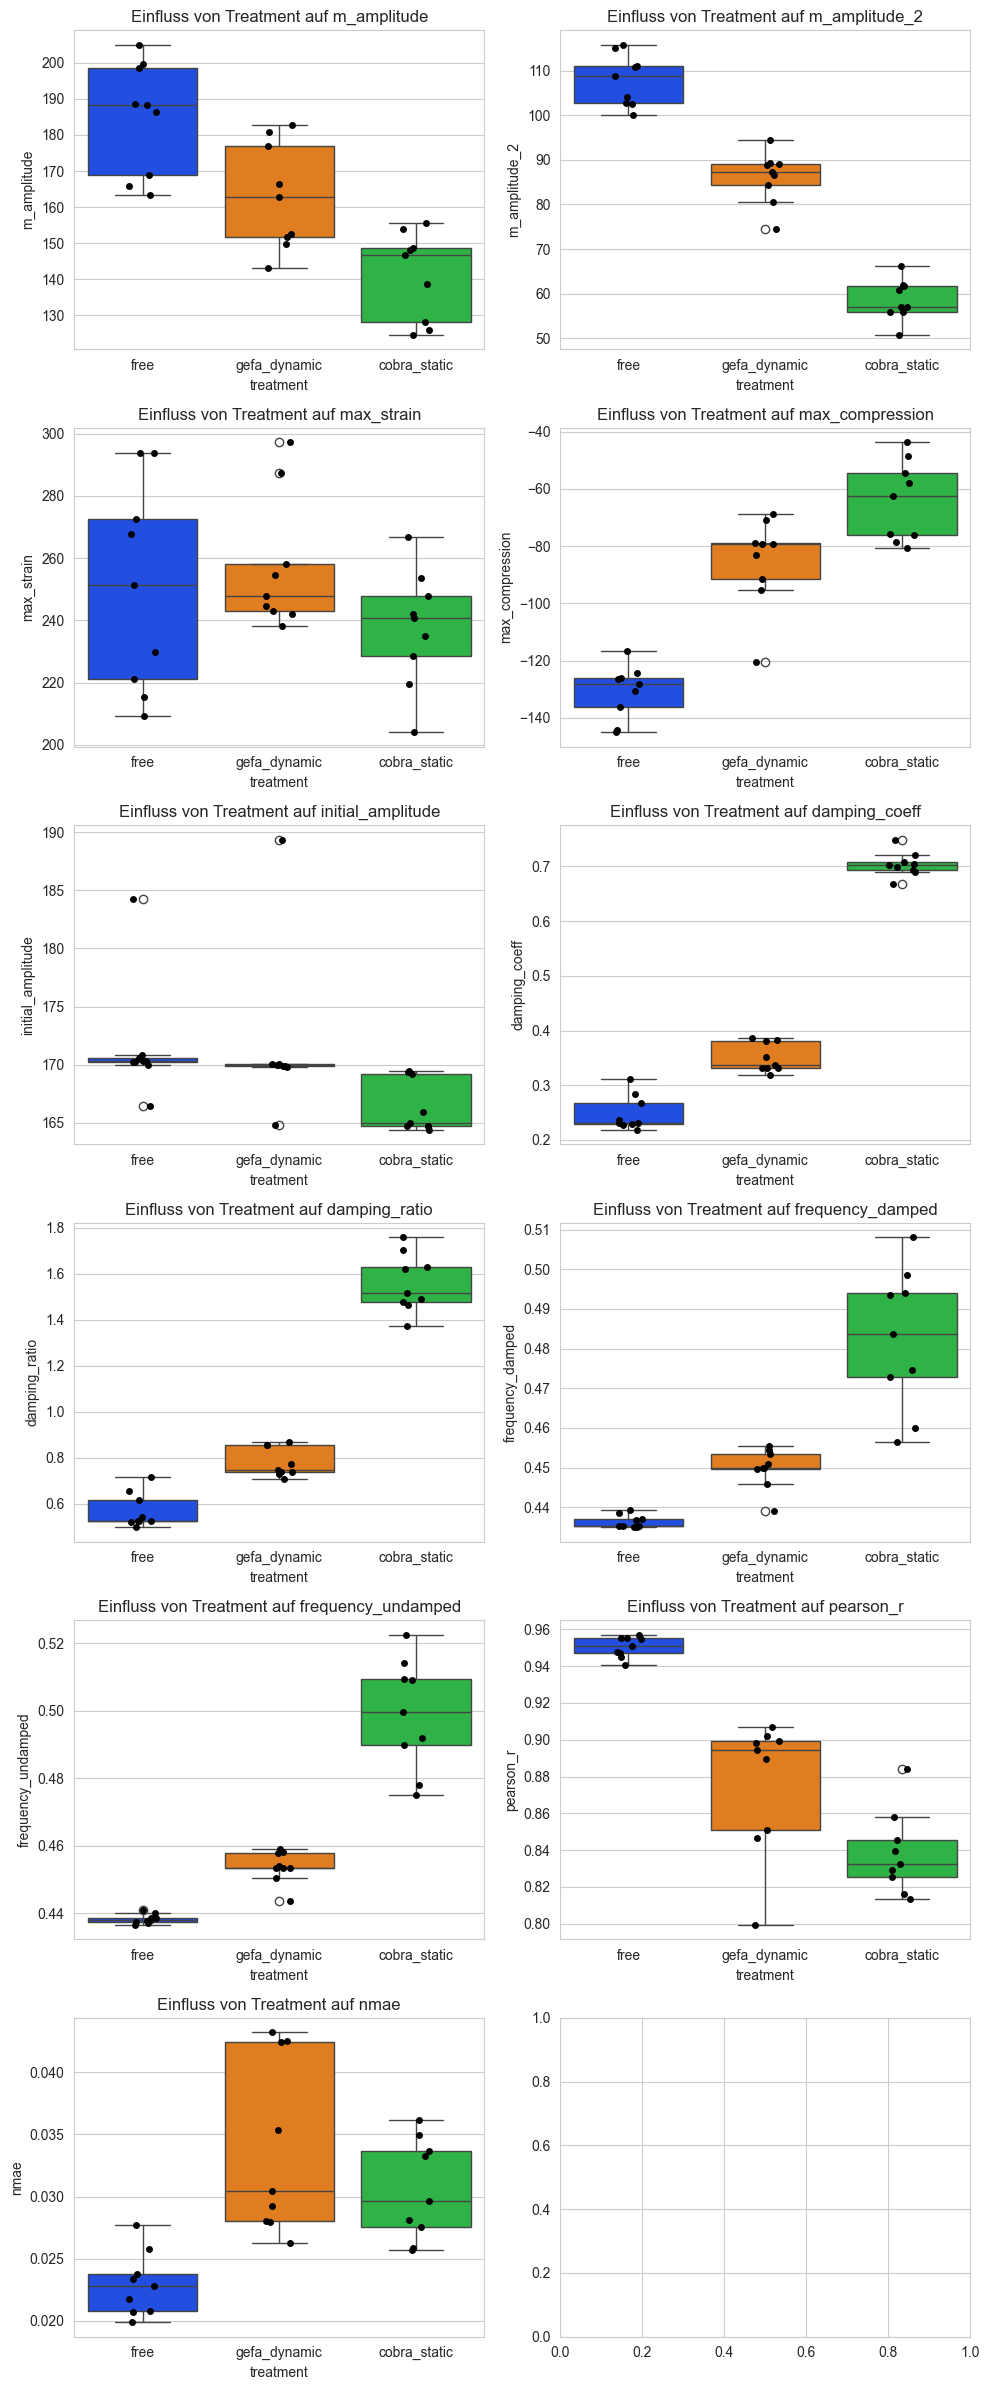

In [87]:
# Anzahl der relevanten Variablen und Layout für die Subplots definieren
n_vars, n_cols, n_rows = len(variables), 2, (len(variables) + 1) // 2

# Subplots erstellen
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes = axes.flatten()

# Für jede relevante Variable einen Plot erstellen
for i, var in enumerate(variables):
    sns.boxplot(ax=axes[i], x="treatment", y=var, data=grouped_df, palette=treatment_color_dict, hue="treatment", legend=False, dodge=False)
    sns.stripplot(ax=axes[i], x="treatment", y=var, data=grouped_df, dodge=False, c="black", jitter=True, size=5)
    axes[i].set_title(f"Einfluss von Treatment auf {var}")
    axes[i].set_ylabel(var)

# Layout anpassen, Plot anzeigen und speichern
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig, filename="effect_of_treatment_with_rope_release", subdir="combined")


Für die betroffenen Parameter wird der Einfluss von `rope_release` mithilfe der bereits angepassten Modelle (`Parameter ~ C(treatment) + rope_release`) entfernt. Dazu werden Vorhersagen für einen konstanten `rope_release`-Wert (den Mittelwert) berechnet und mit den tatsächlichen Werten verglichen. Die daraus resultierenden bereinigten Werte sind frei von Variation, die auf `rope_release` zurückzuführen wäre.

In [88]:
grouped_adjusted_df = grouped_df.copy()

# Bereinigung: Wir setzen rope_release auf seinen Mittelwert
rope_mean = grouped_df["rope_release"].mean()

for var in relevant_vars_rope_release:
    # Zugehöriges Modellobjekt abrufen
    model = results[var]["model"]

    # Vorhersage mit tatsächlichen rope_release-Werten
    predicted_current = model.predict(grouped_df)

    # Vorhersage, wenn rope_release = rope_mean gesetzt wird
    df_mean_rope = grouped_df.copy()
    df_mean_rope["rope_release"] = rope_mean
    predicted_mean = model.predict(df_mean_rope)

    # Angepasste Werte berechnen:
    actual = grouped_df[var].values
    adjusted = actual + (predicted_mean - predicted_current)
    grouped_adjusted_df[var] = adjusted

In [89]:
grouped_df.describe()

,id,m_amplitude,m_amplitude_2,max_strain,max_compression,initial_amplitude,damping_coeff,damping_ratio,frequency_damped,frequency_undamped,pearson_r,nmae,rope_release
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,15.000000,163.041667,84.181019,248.391667,-93.480556,169.790250,0.434036,0.968812,0.456238,0.463587,0.888360,0.029134,2.371609
std,7.937254,22.751519,21.178032,25.407331,31.077756,5.462118,0.200727,0.442173,0.022212,0.027848,0.053055,0.006646,0.320477
min,2.000000,124.700000,50.825000,204.125000,-144.950000,164.414861,0.218833,0.499237,0.435009,0.436606,0.799567,0.019889,1.946800
25%,8.500000,148.368750,61.868750,232.437500,-125.262500,166.161477,0.276357,0.636314,0.437784,0.439283,0.842485,0.024730,2.012975
50%,15.000000,162.850000,87.362500,244.750000,-80.800000,169.854061,0.336295,0.748273,0.450018,0.453386,0.894191,0.027968,2.356550
75%,21.500000,181.712500,102.618750,262.400000,-73.425000,170.241598,0.692071,1.469274,0.466431,0.483996,0.946130,0.033468,2.748225
max,28.000000,204.950000,115.737500,297.150000,-43.775000,189.345841,0.748626,1.757161,0.508053,0.522475,0.956986,0.043212,2.780700


In [90]:
grouped_adjusted_df.describe()

,id,m_amplitude,m_amplitude_2,max_strain,max_compression,initial_amplitude,damping_coeff,damping_ratio,frequency_damped,frequency_undamped,pearson_r,nmae,rope_release
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,15.000000,163.041667,84.181019,248.391667,-93.480556,169.790250,0.434036,0.968812,0.456238,0.463587,0.888360,0.029134,2.371609
std,7.937254,18.891324,20.934729,16.410959,30.794404,5.462118,0.200727,0.442173,0.022212,0.027848,0.053055,0.006646,0.320477
min,2.000000,131.846701,51.130191,217.448634,-144.819087,164.414861,0.218833,0.499237,0.435009,0.436606,0.799567,0.019889,1.946800
25%,8.500000,144.118384,61.463834,237.916325,-120.499666,166.161477,0.276357,0.636314,0.437784,0.439283,0.842485,0.024730,2.012975
50%,15.000000,163.656850,87.638609,245.794064,-83.425374,169.854061,0.336295,0.748273,0.450018,0.453386,0.894191,0.027968,2.356550
75%,21.500000,183.080648,105.994447,263.222750,-73.172790,170.241598,0.692071,1.469274,0.466431,0.483996,0.946130,0.033468,2.748225
max,28.000000,188.972395,111.515511,273.401709,-37.392337,189.345841,0.748626,1.757161,0.508053,0.522475,0.956986,0.043212,2.780700


##### Latex Tabelle Output


In [91]:
data_dict

{'id': {'Kategorie': 'ptq',
  'Zeichen': 'ID',
  'Deutsch': 'ID Messung',
  'Datentyp': 'int64',
  'Einheit': '-',
  'Beschreibung': 'Eindeutige ID der Messung'},
 'rope_datetime': {'Kategorie': 'ls3',
  'Zeichen': '$t$',
  'Deutsch': 'Zeitstempel',
  'Datentyp': 'object',
  'Einheit': '-',
  'Beschreibung': 'Startzeitpunkt der Messung laut Gerät'},
 'treatment': {'Kategorie': 'series',
  'Zeichen': 'treatment',
  'Deutsch': 'Behandlung',
  'Datentyp': 'category',
  'Einheit': '-',
  'Beschreibung': 'Art der KS: \\texttt{free}, \\texttt{gefa\\_dynamic}, \\texttt{cobra\\_static}'},
 'release_force_target': {'Kategorie': 'series',
  'Zeichen': '$F_{\\mathrm{release,target}}$',
  'Deutsch': 'Vorspannkraft-Soll',
  'Datentyp': 'float64',
  'Einheit': 'kN',
  'Beschreibung': 'Geplante Vorspannkraft im Zugseil bei Release'},
 'rope_release': {'Kategorie': 'ls3',
  'Zeichen': '$F_{\\mathrm{release}}$',
  'Deutsch': 'Vorspannkraft Ist',
  'Datentyp': 'float64',
  'Einheit': 'kN',
  'Beschreibu

In [92]:
# DataFrame mit den relevanten Spalten erstellen
variables_latex = [
    'm_amplitude', 
    'm_amplitude_2',
    'initial_amplitude',
    'damping_coeff', 
    'damping_ratio', 
    'frequency_damped', 
    'frequency_undamped',
    'pearson_r',
    'nmae'
]
df_latex = grouped_adjusted_df[variables_latex + ['treatment']].copy()
df_latex.columns

Index(['m_amplitude', 'm_amplitude_2', 'initial_amplitude', 'damping_coeff',
       'damping_ratio', 'frequency_damped', 'frequency_undamped', 'pearson_r',
       'nmae', 'treatment'],
      dtype='object')

In [93]:


# Spaltennamen entsprechend der LaTeX-Notation umbenennen
df_latex.rename(columns=data_dict, inplace=True)

# Erstellung deskriptiver Statistiken für alle Beobachtungen
overall_stats = df_latex.describe().drop(index=['count', '25%', '75%'])
overall_stats.rename(index={'50%': 'median'}, inplace=True)

# Erstellung der deskriptiven Statistiken für jede Gruppe
grouped_stats = {
    'overall': overall_stats
}

for treatment, group in df_latex.groupby('treatment', observed=True):
    group_stats = group.describe().drop(index=['count', '25%', '75%'])
    group_stats.rename(index={'50%': 'median'}, inplace=True)
    grouped_stats[treatment] = group_stats

# Zusammenführen der Statistiken in einer Tabelle
combined_stats = pd.concat(grouped_stats, names=['Treatment'])

# LaTeX-Export des kombinierten DataFrames
df_latex_string = combined_stats.to_latex(
    escape=False,
    multirow=True,
    multicolumn=True,
    column_format="l|lrrrrrrrrr", 
    float_format="{:0.2f}".format
)

# LaTeX-Tabellencode erstellen
latex_table = f"""
\\begin{{table}}[h]
    \\centering
    \\caption{{Feldversuch 2 - Ergebnisse, Schwingungsparameter deskriptive Statistiken (Gesamt und gruppiert über Treatment), Amplituden korrigiert über \\texttt{{rope\\_release}}, 9 Beobachtung je Gruppe, jeweils Mittelwert für 4 Elastometer}}
    \\begin{{adjustbox}}{{max width=\\textwidth}}
    {df_latex_string}
    \\end{{adjustbox}}
    \\label{{tab:Feldversuch_2_Deskriptive_Statistiken_Schwingungsparameter}}
\\end{{table}}
"""

print(latex_table)

TypeError: unhashable type: 'dict'

#### Visualisierung der bereinigten Ergebnisse

Abschließend werden die bereinigten Werte grafisch dargestellt, um die Unterschiede zwischen den Behandlungen in Abwesenheit des `rope_release`-Einflusses zu verdeutlichen. Dies zeigt, wie sich die Treatments auf die Parameter auswirken würden, wenn für alle Einheiten die gleiche mittlere Vorspannung gelten würde.

In [ ]:
relevant_vars_rope_release = ['m_amplitude', 'm_amplitude_2', 'max_strain', 'max_compression']

n_vars = len(relevant_vars_rope_release)
n_cols = 2  # Links Original, rechts angepasst
n_rows = n_vars  # Eine Zeile pro Variable

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))

for i, var in enumerate(relevant_vars_rope_release):
    # Linke Spalte: Original (grouped_df)
    sns.boxplot(ax=axes[i,0], x="treatment", y=var, data=grouped_df, 
                palette=treatment_color_dict, hue="treatment", legend=False, dodge=False)
    sns.stripplot(ax=axes[i,0], x="treatment", y=var, data=grouped_df, 
                  dodge=False, c="black", jitter=True, size=5)
    axes[i,0].set_title(f"original: {var}")
    axes[i,0].set_ylabel(var)

    # Rechte Spalte: Angepasst (grouped_adjusted_df)
    sns.boxplot(ax=axes[i,1], x="treatment", y=var, data=grouped_adjusted_df, 
                palette=treatment_color_dict, hue="treatment", legend=False, dodge=False)
    sns.stripplot(ax=axes[i,1], x="treatment", y=var, data=grouped_adjusted_df, 
                  dodge=False, c="black", jitter=True, size=5)
    axes[i,1].set_title(f"adjusted : {var}")
    axes[i,1].set_ylabel(var)
    
    # Y-Limits von links holen
    y_min, y_max = axes[i,0].get_ylim()
    # Y-Limits auf rechts anwenden
    axes[i,1].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

PLOT_MANAGER.save_plot(fig, filename="effect_of_treatment_comparison", subdir="combined")


Schritt 2: Durchführung von Post-hoc-Tests

Festzustellen welche paarweisen Unterschiede zwischen den Treatments signifikant sind.

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Wir gehen davon aus, dass grouped_adjusted_df existiert und die Spalten 'treatment' sowie die Variablen aus 'variables' enthält.

for var in variables_spec:
    # Tukey HSD Test durchführen
    # Annahme: Die Spalte 'treatment' enthält die Gruppennamen z.B. 'free', 'gefa_dynamic', 'cobra_static'
    # pairwise_tukeyhsd benötigt die abhängige Variable und die Gruppen.
    tukey_results = pairwise_tukeyhsd(endog=grouped_adjusted_df[var],
                                      groups=grouped_adjusted_df['treatment'],
                                      alpha=0.05)
    
    print(f"--- Post-Hoc Test (Tukey HSD) für Variable: {var} ---")
    print(tukey_results.summary())
    print("\n")


In [ ]:
# Anzahl der relevanten Variablen und Layout für die Subplots definieren
n_vars, n_cols, n_rows = len(variables_spec), 2, (len(variables_spec) + 1) // 2

# Subplots erstellen
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes = axes.flatten()

# Für jede relevante Variable einen Plot erstellen
for i, var in enumerate(variables_spec):
    sns.boxplot(ax=axes[i], x="treatment", y=var, data=grouped_adjusted_df, palette=treatment_color_dict, hue="treatment", legend=False, dodge=False)
    sns.stripplot(ax=axes[i], x="treatment", y=var, data=grouped_adjusted_df, dodge=False, c="black", jitter=True, size=5)
    axes[i].set_title(f"Einfluss von Treatment auf {var}")
    axes[i].set_ylabel(var)

# Layout anpassen, Plot anzeigen und speichern
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig, filename="effect_of_treatment_without_rope_release", subdir="combined")

In [ ]:
# Anzahl der relevanten Variablen und Layout für die Subplots definieren
n_vars, n_cols, n_rows = len(variables_spec), 2, (len(variables_spec) + 1) // 2

# Subplots erstellen
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
axes = axes.flatten()

# Für jede relevante Variable einen Plot erstellen
for i, var in enumerate(variables_spec):
    sns.boxplot(ax=axes[i], x="treatment", y=var, data=grouped_adjusted_df, palette=treatment_color_dict, hue="treatment", legend=False, dodge=False)
    sns.stripplot(ax=axes[i], x="treatment", y=var, data=grouped_adjusted_df, dodge=False, c="black", jitter=True, size=5)
    axes[i].set_title(f"Einfluss von Treatment auf {var}")
    axes[i].set_ylabel(var)

# Layout anpassen, Plot anzeigen und speichern
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig, filename="effect_of_treatment_without_rope_release_spec", subdir="combined")

#### Vorhergesagte Werte extrahieren und Boxplots für die Sensoren erstellen

In [ ]:
# Vorhergesagte Werte aus den Modellen extrahieren
for variable in variables:
    df[f'predicted_{variable}'] = models[variable].fittedvalues

# Boxplots erstellen mit den vorhergesagten Werten
fig, axes = plt.subplots(4, 2, figsize=(8, 8))
axes = axes.flatten()

for i, variable in enumerate(variables):
    sns.boxplot(ax=axes[i], x='treatment', y=f'predicted_{variable}', data=df, palette=treatment_color_dict, hue='treatment', dodge=False, legend=False)
    axes[i].set_title(f'{variable} by Treatment')
    axes[i].set_xlabel('Treatment')
    axes[i].set_ylabel(f'Predicted {variable}')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig, filename="predicted_effect_for_treatment", subdir="combined")

In [ ]:
def annotate_tukey(ax, tukey_result, significance_level=0.05):
    """
    Fügt eine Textbox mit den Tukey-Test-Ergebnissen und dem festgelegten Signifikanzniveau in den Plot ein.
    
    Parameters:
    ax (matplotlib.axes): Die Achse, auf der der Plot gezeichnet wird.
    tukey_result (TukeyHSDResults): Die Ergebnisse des Tukey HSD Tests.
    significance_level (float): Das Signifikanzniveau, standardmäßig 0.05.
    """
    # Definiere die gewünschte Reihenfolge der Vergleiche
    comparisons_order = [('free', 'gefa_dynamic'), ('free', 'cobra_static'), ('gefa_dynamic', 'cobra_static')]

    # Text für die Annotation zusammenstellen
    text_str = f"Tukey HSD Results: \n(Significance level = {significance_level:.2f})\n\n"
    
    # Durchlaufe die gewünschte Vergleichsreihenfolge
    for group1, group2 in comparisons_order:
        # Filtere die korrekte Paarung aus den Tukey-Ergebnissen
        for i in range(len(tukey_result._results_table.data[1:])):
            pair = tukey_result._results_table.data[i + 1]
            if (pair[0] == group1 and pair[1] == group2) or (pair[0] == group2 and pair[1] == group1):
                p_value = tukey_result.pvalues[i]
                significance = "*" if p_value < significance_level else "n.s."
                text_str += f"\n{group1} vs {group2}: \np = {p_value:.4f} ({significance})\n\n"
    
    # Textbox am Rand des Plots hinzufügen
    ax.annotate(text_str, xy=(1.01, 0.1), xycoords='axes fraction', va='center', ha='left')

# Einzelne Plots für jede Variable erstellen und speichern
for variable in variables:
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Boxplot für die aktuelle Variable
    sns.boxplot(ax=ax, x='treatment', y=f'predicted_{variable}', data=df, 
                palette=treatment_color_dict, hue='treatment', dodge=False, legend=False)
    
    # Tukey-Test für die aktuelle Variable
    tukey_result = tukey_results[variable]
    
    # Tukey-Ergebnisse annotieren
    annotate_tukey(ax, tukey_result)
    
    ax.set_title(f'{variable} by Treatment')
    ax.set_xlabel('Treatment')
    ax.set_ylabel(f'Predicted {variable}')
    
    plt.tight_layout()
    plt.show()

    # Plot speichern
    plot_filename = f"{variable}_effect_for_treatment"
    PLOT_MANAGER.save_plot(fig, filename=plot_filename, subdir="osc_variables_box")


In [ ]:
# Gruppieren des DataFrames nach 'treatment' und Entfernen unnötiger Spalten
df_treatment_describe = (df.drop(['id', 'ptq_sensor_name'], axis=1)
                         .groupby('treatment', observed=True)
                         .describe())

df_treatment_describe = df_treatment_describe.reset_index()
df_treatment_describe.round(2)

In [ ]:
df.dtypes

In [ ]:
# Gruppieren des DataFrames nach 'treatment' und Entfernen unnötiger Spalten
df_sensor = (df.drop(['id', 'release_force_target', 'ls3_rope_release', 'ls3_cable_max', 'location', 'height', 'diameter', 'direction'], axis=1).
             groupby(['treatment', 'ptq_sensor_name'], observed=True).
             mean())  #.T
#df_sensor.round(4)

In [ ]:
# Gruppieren des DataFrames und Anwenden von mean für ptq_sensor_name 
df_id = ((df.drop(['ptq_sensor_name', 'location', 'height', 'diameter', 'direction'], axis=1)
          .groupby(['treatment', 'id'], observed=True)
          .mean())
         .reset_index())

df_id.round(4).head()

### Zusammenhangsanalyse für LS3 und PTQ

In [ ]:
# Auswahl der neuen Spaltennamen für die Korrelationsmatrix
columns_corr = ['ptq_m_amplitude',
                'ptq_m_amplitude_2',
                'ptq_initial_amplitude',
                'ptq_damping_coeff',
                'ptq_angular_frequency',
                'ptq_y_shift',
                'ptq_pearson_r',
                #'ptq_nrmse',
                'ptq_nmae',
                'release_force_target',
                'ls3_rope_release',
                'ls3_cable_max']
df_corr = df_id.copy()[columns_corr]

# Berechnung der Korrelationsmatrix
correlation_matrix = df_corr.corr()

# Visualisierung der Korrelationsmatrix mit Seaborn
fig1, ax = plt.subplots(figsize=(8, 8))  # Anpassen der Größe der Grafik
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=ax, annot_kws={'size': 10})

# Titel und Schriftgrößen anpassen
#plt.title('Correlation Matrix for LS3 and PTQ', fontsize=18)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=12, rotation=45, ha='right')
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=12, rotation=45, ha='right')
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig1, filename="correlation_matrix", subdir="combined")

In [ ]:
# ANOVA für 'ls3_rope_release'
model_rope_release = smf.ols('ls3_rope_release ~ treatment', data=df_id).fit()
anova_rope_release = sm.stats.anova_lm(model_rope_release, typ=2)

# ANOVA für 'ls3_cable_max'
model_cable_max = smf.ols('ls3_cable_max ~ treatment', data=df_id).fit()
anova_cable_max = sm.stats.anova_lm(model_cable_max, typ=2)

# Zusammenfassungen der Modelle
summary_rope_release = model_rope_release.summary()
summary_cable_max = model_cable_max.summary()
# Zusammenfassungen der Modelle
summary_rope_release_latex = model_rope_release.summary().as_latex()
summary_cable_max_latex = model_cable_max.summary().as_latex()

#print(summary_rope_release_latex)
#print(summary_cable_max_latex)

anova_rope_release, summary_rope_release, anova_cable_max, summary_cable_max

#### Zusammenhang Vorspannung und resultierende Lastspitzen

In [ ]:
fig3, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()
ax2.axis('off')
y_pos_init = 0.1
for idx, (treatment, color) in enumerate(treatment_color_dict.items()):
    subset = df_id[df_id['treatment'] == treatment]
    if subset['ptq_m_amplitude'].isna().all():
        continue
    sns.regplot(x='ls3_rope_release', y='ptq_m_amplitude', data=subset, ax=ax1, color=color, label=treatment,
                ci=95)
    stats_text = annotate_stats(subset['ls3_rope_release'], subset['ptq_m_amplitude'])
    ax2.annotate(f"{treatment}:\n{stats_text}", xy=(1.01, y_pos_init + idx * 0.3), xycoords='axes fraction')
#ax1.set_title('Correlation Between Release Force and Elongation Amplitude')
ax1.set_xlabel('Release Force [kN]')
ax1.set_ylabel('Elongation Amplitude [$\mu$m] (mean for all Sensors)')
ax1.legend(title='Treatment', loc='upper left')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig3, filename=f"ls3_release_force_vs_ptq_m_amplitude", subdir="combined")


In [ ]:
fig3, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()
ax2.axis('off')
y_pos_init = 0.1
for idx, (treatment, color) in enumerate(treatment_color_dict.items()):
    subset = df_id[df_id['treatment'] == treatment]
    if subset['ptq_m_amplitude_2'].isna().all():
        continue
    sns.regplot(x='ls3_rope_release', y='ptq_m_amplitude_2', data=subset, ax=ax1, color=color, label=treatment,
                ci=95)
    stats_text = annotate_stats(subset['ls3_rope_release'], subset['ptq_m_amplitude_2'])
    ax2.annotate(f"{treatment}:\n{stats_text}", xy=(1.01, y_pos_init + idx * 0.3), xycoords='axes fraction')
#ax1.set_title('Correlation Between Release Force and Elongation Amplitude 2')
ax1.set_xlabel('Release Force [kN]')
ax1.set_ylabel('Elongation Amplitude 2 [$\mu$m] (mean for all Sensors)')
ax1.legend(title='Treatment', loc='upper left')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig3, filename=f"ls3_release_force_vs_ptq_m_amplitude_2", subdir="combined")

In [ ]:
# Funktion zur Durchführung des ANOVA-Tests und Berechnung der Effektstärke (Eta Squared)
def perform_anova_and_effect_size(df: pd.DataFrame, variable: str, treatments: List[str]) -> str:
    groups = [df[df['treatment'] == treatment][variable].dropna() for treatment in treatments]
    f_stat, p_value = f_oneway(*groups)

    # Berechnung der Effektstärke (Eta Squared)
    n = sum([len(g) for g in groups])
    ss_total = sum([(x - df[variable].mean()) ** 2 for g in groups for x in g])
    eta_squared = f_stat * len(groups) / (f_stat * len(groups) + (n - len(groups)))

    # Überprüfung der Signifikanz
    significance = "*" if p_value < 0.05 else ""

    return f"{variable}: {significance}\nF-statistic = {f_stat:.2f}\np-value = {p_value:.2e}\nEta Squared = {eta_squared:.2f}"

In [ ]:
# Funktion zur Erstellung von Boxplots
def create_boxplot(df: pd.DataFrame, variable: str, group_by: str, ax: plt.Axes, color_dict: Dict[str, str], perform_stats: bool) -> None:
    valid_df = df.dropna(subset=[variable])
    sns.boxplot(x=group_by, y=variable, hue=group_by, data=valid_df, ax=ax, palette=color_dict, dodge=False)
    ax2 = ax.twinx()
    ax2.axis('off')
    if perform_stats:
        stats_text = perform_anova_and_effect_size(valid_df, variable, valid_df[group_by].unique())
        ax2.annotate(stats_text, xy=(1.01, 0.1), xycoords='axes fraction')
    ax.set_title(f'Einfluss von {group_by} auf {variable}')
    ax.set_xlabel(group_by)
    ax.set_ylabel(variable)

# Funktion zur Erstellung kombinierter Plots
def create_combined_plot(df: pd.DataFrame, columns: List[str], group_by: str, color_dict: Dict[str, str], num_columns: int = 3, perform_stats: bool = False) -> None:
    num_rows = len(columns) // num_columns + (len(columns) % num_columns > 0)
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 4 * num_rows))
    axes = axes.flatten()

    for idx, variable in enumerate(columns):
        create_boxplot(df, variable, group_by, axes[idx], color_dict, perform_stats)

    plt.tight_layout()
    plt.show()
    PLOT_MANAGER.save_plot(fig, filename=f"combined_plot_{group_by}", subdir="combined")

# Funktion zur Erstellung einzelner Plots
def create_individual_plots(df: pd.DataFrame, columns: List[str], group_by: str, color_dict: Dict[str, str], perform_stats: bool = False) -> None:
    for variable in columns:
        fig, ax = plt.subplots(figsize=(8, 5))
        create_boxplot(df, variable, group_by, ax, color_dict, perform_stats)
        plt.tight_layout()
        #plt.show()
        PLOT_MANAGER.save_plot(fig, filename=f"{group_by}_{variable}", subdir="individual_plots")

In [ ]:
columns = ['ptq_m_amplitude',
           'ptq_m_amplitude_2',
           'ptq_initial_amplitude',
           'ptq_damping_coeff',
           'ptq_angular_frequency',
           'ptq_y_shift',
           'ptq_pearson_r',
           #'ptq_nrmse',
           #'ptq_nmae',
           #'release_force_target',
           'ls3_rope_release',
           'ls3_cable_max'
           ]

# Beispiel: Erstellen von Plots gruppiert nach 'treatment'
create_combined_plot(df, columns, 'treatment', treatment_color_dict, perform_stats=True)
create_individual_plots(df, columns, 'treatment', treatment_color_dict, perform_stats=True)

In [ ]:
# Beispiel: Erstellen von Plots gruppiert nach 'ptq_sensor_name'
columns = ['ptq_m_amplitude', 'ptq_m_amplitude_2', 'ptq_initial_amplitude', 'ptq_damping_coeff', 'ptq_angular_frequency', 'ptq_pearson_r']

create_combined_plot(df, columns, 'ptq_sensor_name', sensor_color_dict)
create_individual_plots(df, columns, 'ptq_sensor_name', sensor_color_dict)